In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")

from tqdm import tqdm_notebook
import argparse
paser = argparse.ArgumentParser()
args = paser.parse_args("")

import keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models

Using TensorFlow backend.


In [2]:
data = pd.read_csv('data/train.csv')
data = data.sample(frac=1)
x_data, y_data = np.array(data[data.columns[4:]]), np.array(data[data.columns[:4]])

x_std = np.std(x_data, axis=1).reshape(x_data.shape[0], 1)
x_mean = np.mean(x_data, axis=1).reshape(x_data.shape[0], 1)

x_train = (x_data - x_mean) / x_std
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)

y_norm = np.max(y_data)
y_train = 0.98*(y_data/y_norm)+0.01

print('x_train shape: {}'.format(x_train.shape))
print('y_train shape: {}'.format(y_train.shape))

x_train shape: (810000, 226, 1)
y_train shape: (810000, 4)


In [3]:
def keras_train(args, X_train, y_train):
    
    model_folder = args.model_folder
    if not os.path.isdir(model_folder):
        os.mkdir(model_folder)

    def conv1d_block(input_layer):
        x = layers.Conv1D(64, 5, kernel_initializer='he_normal')(input_layer)
        t = layers.ReLU()(x)    
        x = layers.Conv1D(64, 5, padding='same', kernel_initializer='he_normal')(t)
        x = layers.add([t, x])
        x = layers.ReLU()(x)
        x = layers.MaxPooling1D(2)(x)
        x = layers.BatchNormalization()(x)
        return x
    
    def thickness_encoder(x):
        x = layers.Dense(426, activation='relu', kernel_initializer='he_normal')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(426, activation='relu', kernel_initializer='he_normal')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(426, activation='relu', kernel_initializer='he_normal')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(1, activation='sigmoid')(x)        
        return x
    
    K.clear_session()
    callbacks = [] 
    mc = tf.keras.callbacks.ModelCheckpoint(
        model_folder + 'weights_{epoch:04d}.h5',
        save_weights_only=True, 
        period=1
    )
    callbacks.append(mc)
    
    input_layer = layers.Input(shape=(X_train.shape[1],X_train.shape[2]))
    x = conv1d_block(input_layer)
    x = conv1d_block(x)
    x = conv1d_block(x)
    x = conv1d_block(x)
    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)
    
    layer_1 = thickness_encoder(x)
    layer_2 = thickness_encoder(x)
    layer_3 = thickness_encoder(x)
    layer_4 = thickness_encoder(x)

    x = layers.concatenate([layer_1, layer_2, layer_3, layer_4], axis=-1)
    model = models.Model(input_layer, x)
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])    
    
    # Save structure
    structure_path = model_folder + 'structure.json' 
    structure = model.to_json()
    with open(structure_path, 'w') as f:
        f.write(structure)
       
    if args.scheduler:        
        def scheduler(epoch):
            a = 50
            b = 50
            if epoch <= a:
                return 1e-3
            else: 
                return 1e-3*np.exp(-(epoch-a)/b)        
        callback = tf.keras.callbacks.LearningRateScheduler(scheduler) 
        callbacks.append(callback)
        
        ep = np.linspace(1, args.epochs, args.epochs)
        lr = []
        for epoch in ep:
            lr.append(scheduler(epoch))
        plt.plot(ep, np.log10(lr))
        plt.xlim(0, args.epochs)
        plt.xlabel('Epochs')
        plt.ylabel('Log. Learning rate')
        plt.show()        
    
    if args.summary:        
        model.summary()
    
    if args.train:
        history = model.fit(
            X_train, y_train, 
            epochs=args.epochs, 
            batch_size=args.batch_size, 
            verbose=args.verbose, 
            validation_split=0.2, 
            shuffle=True, 
            callbacks=callbacks
        )

        if args.plot:
            plt.plot(np.log10(history.history['loss']), label='loss')
            plt.plot(np.log10(history.history['val_loss']), label='val_loss')
            plt.legend()
            plt.xlabel('Epochs')
            plt.ylabel('Log Loss')
            plt.xlim(0, args.epochs)
            plt.show()
            
        return model
    else:
        print('Non-train mode')

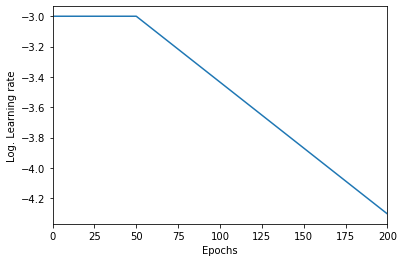

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 226, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 222, 64)      384         input_1[0][0]                    
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 222, 64)      0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 222, 64)      20544       re_lu[0][0]                      
______________________________________________________________________________________________

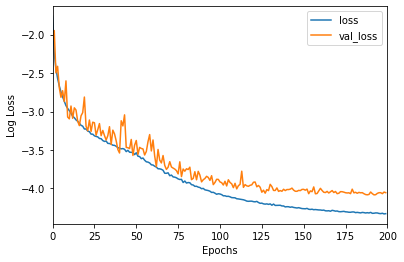

In [4]:
args.model_folder = 'model_191229_0/'
args.epochs = 200
args.batch_size = 256
args.verbose = 1
args.summary = True
args.scheduler = True
args.train = True
args.plot = True
model = keras_train(args, x_train, y_train)